In [1]:
!pip install numpy-ext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2


In [2]:
import re
import pytz

import matplotlib . pyplot as plt
import scipy.stats as scist

import statsmodels.formula.api as smf

from pprint import pprint

from datetime import datetime
from datetime import timedelta

import yfinance as yf

import pandas as pd

import numpy as np
import numpy_ext as npe

import warnings
warnings.filterwarnings("ignore")


# 천연가스 ETF의 심볼
contract = 'NG=F'

# 데이터 가져오기 (최초 데이터 2000년 8월 31일부터 현재까지)
data = yf.download(contract, start='2000-08-31', end='2024-11-01')
data['Log Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

contract_df = data[['Log Return']].dropna()
contract_df = contract_df.rename(columns={'Log Return':'cont_ret'})

# 데이터 출력
contract_df

[*********************100%***********************]  1 of 1 completed


Price,cont_ret
Ticker,
Date,
2000-09-01 00:00:00+00:00,0.011441
2000-09-05 00:00:00+00:00,0.025525
2000-09-06 00:00:00+00:00,0.020948
2000-09-07 00:00:00+00:00,-0.013316
2000-09-08 00:00:00+00:00,-0.023893
...,...
2024-10-25 00:00:00+00:00,0.014955
2024-10-28 00:00:00+00:00,-0.103193


In [3]:
# contract , contract_df = "NG", pd. DataFrame () # retrieve data
mgrps = contract_df.groupby (by =[ contract_df.index.month , contract_df.index.year ])
classical_df = pd.concat ([(1+ mgrps.get_group(group).cont_ret ).cumprod ().tail (1) -1 for group in mgrps.groups ])
classical_df = classical_df.loc[ sorted ( classical_df.index )]
classical_df = pd.DataFrame ( index = classical_df.index , data ={"date": classical_df.index , "cont_ret": classical_df.values })
classical_df ["positions"]= np.nan

In [4]:
print(classical_df.iloc[:1])
print((contract_df.iloc[:20] + 1).cumprod().tail(1) -  1)
contract_df.iloc[:20]

                                               date  cont_ret  positions
Date                                                                    
2000-09-29 00:00:00+00:00 2000-09-29 00:00:00+00:00  0.083747        NaN
Price                      cont_ret
Ticker                             
Date                               
2000-09-29 00:00:00+00:00  0.083747


Price,cont_ret
Ticker,
Date,
2000-09-01 00:00:00+00:00,0.011441
2000-09-05 00:00:00+00:00,0.025525
2000-09-06 00:00:00+00:00,0.020948
2000-09-07 00:00:00+00:00,-0.013316
2000-09-08 00:00:00+00:00,-0.023893
2000-09-11 00:00:00+00:00,0.027288
2000-09-12 00:00:00+00:00,-0.001996
2000-09-13 00:00:00+00:00,0.009940


In [5]:
mgrps.get_group((9, 2000))

Price,cont_ret
Ticker,
Date,
2000-09-01 00:00:00+00:00,0.011441
2000-09-05 00:00:00+00:00,0.025525
2000-09-06 00:00:00+00:00,0.020948
2000-09-07 00:00:00+00:00,-0.013316
2000-09-08 00:00:00+00:00,-0.023893
2000-09-11 00:00:00+00:00,0.027288
2000-09-12 00:00:00+00:00,-0.001996
2000-09-13 00:00:00+00:00,0.009940


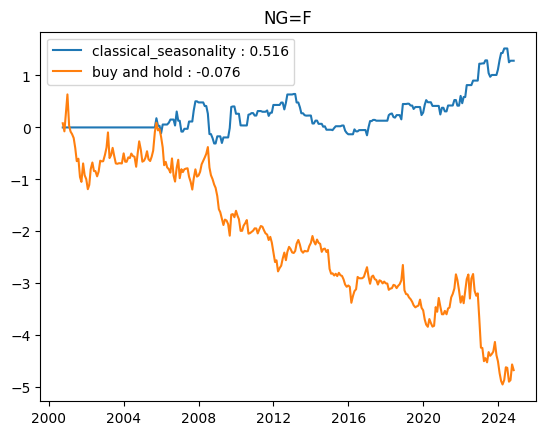

In [6]:
def classical_roll (dt ,r):
  df=pd. DataFrame ( index =dt , data ={"r":r})
  if not np. isnan (classical_df.at[dt[12*5] , 'positions']):
    return
  calibrate_df =df.loc [: dt [12*5]] # first 5 year positions
  mnth_grps = calibrate_df . groupby (by= calibrate_df . index . month )
  mnthlies ={ grp: np. mean ( mnth_grps.get_group (grp).r. values ) for grp in mnth_grps.groups }
  mnthlies ={k:v for k,v in sorted ( mnthlies . items () , key= lambda pair : pair [1]) }
  short , long = list ( mnthlies . keys ())[:3] , list ( mnthlies . keys ())[ -3:]
  positions =[ -1 if i. month in short else (1 if i. month in long else 0) for i in dt[12*5:]] # next one year positions
  classical_df["positions"].loc [dt[12*5:]] = positions

if len( classical_df ) > 12*6:
  rollop = npe.rolling_apply (classical_roll , 12*6, *classical_df[["date","cont_ret"]].T.values)
  classical_df = classical_df . fillna (0.0)
  classical_df ["classical_portfolio"]= classical_df.positions * classical_df.cont_ret
  ret_bnh = classical_df.cont_ret .loc [ classical_df.cont_ret != 0]. values
  ret_sea = classical_df.classical_portfolio.loc [ classical_df.classical_portfolio!= 0]. values
  shrp_sea = round (np. mean ( ret_sea )/np.std( ret_sea )*np. sqrt (12) ,3)
  shrp_bnh = round (np. mean ( ret_bnh )/np.std( ret_bnh )*np. sqrt (12) ,3)

  plt. plot (np.log ((1+ classical_df . classical_portfolio ). cumprod ()),label =f"classical_seasonality : { shrp_sea }")
  plt. plot (np.log ((1+ classical_df . cont_ret ). cumprod ()),label =f"buy and hold : {shrp_bnh }")
  plt. title ( contract )
  plt. legend ()
  plt. show ()
  plt. close ()

In [7]:
classical_df.iloc[-12:]

,date,cont_ret,positions,classical_portfolio
Date,,,,
2023-11-30 00:00:00+00:00,2023-11-30 00:00:00+00:00,-0.224263,0.0,-0.000000
2023-12-29 00:00:00+00:00,2023-12-29 00:00:00+00:00,-0.111177,-1.0,0.111177
2024-01-31 00:00:00+00:00,2024-01-31 00:00:00+00:00,-0.206406,-1.0,0.206406
2024-02-29 00:00:00+00:00,2024-02-29 00:00:00+00:00,-0.138636,-1.0,0.138636
2024-03-28 00:00:00+00:00,2024-03-28 00:00:00+00:00,-0.064086,0.0,-0.000000
2024-04-30 00:00:00+00:00,2024-04-30 00:00:00+00:00,0.091107,1.0,0.091107
2024-05-31 00:00:00+00:00,2024-05-31 00:00:00+00:00,0.276820,0.0,0.000000
2024-06-28 00:00:00+00:00,2024-06-28 00:00:00+00:00,-0.011323,0.0,-0.000000
2024-07-31 00:00:00+00:00,2024-07-31 00:00:00+00:00,-0.233657,1.0,-0.233657


In [8]:
def get_primes ( n ) :
  sieve = [ True ] * n
  for i in range (3, int (n **0.5) +1 ,2):
    if sieve [i]:
      sieve [i*i ::2* i]=[ False ]*((n-i*i -1) //(2* i)+1)
  return [2] + [i for i in range (3,n ,2) if sieve [i]]

def _get_feature_matrix (m,n):
  primes = get_primes(m +1)
  k=len( primes )
  dummies =[]
  for xk in range (k):
    arr =np. zeros (n)
    arr [ primes [xk ] -1:: primes [xk ]] = 1
    dummies . append (arr )
  X = np. vstack ( dummies ).T
  return X, primes, k

In [9]:
# m : 소수 찾을 범위, n : 시계열 길이
print(_get_feature_matrix(m=8,n=16))

(array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 1., 0.],
       [0., 0., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 1.],
       [0., 1., 1., 0.],
       [1., 0., 0., 0.]]), [2, 3, 5, 7], 4)


In [11]:
monthlies = pd. concat ([(1+ mgrps . get_group ( group ). cont_ret ). cumprod (). tail (1) -1 for group in mgrps . groups ])
monthlies = monthlies .loc[ sorted ( monthlies . index )]

In [12]:
monthlies

,cont_ret
Date,
2000-09-29 00:00:00+00:00,0.083747
2000-10-31 00:00:00+00:00,-0.144237
2000-11-30 00:00:00+00:00,0.439002
2000-12-29 00:00:00+00:00,0.414896
2001-01-31 00:00:00+00:00,-0.452742
...,...
2024-06-28 00:00:00+00:00,-0.011323
2024-07-31 00:00:00+00:00,-0.233657
2024-08-30 00:00:00+00:00,0.030860


In [32]:
'''global in-sample seasonality test and portfolio on monthly returns
'''
# m=5이므로 5 이하의 소수인 [2,3,5] 찾게됨
X,primes,k=_get_feature_matrix(m=5,n=len(monthlies))
kwargs={"X_"+str(i):arr for i,arr in zip(range(k),X.T)}
df=pd.DataFrame(index=monthlies.index, data={"r":monthlies.values, **kwargs})
multiple_tests={}
'''sequential regression testing'''

# x를 하나씩 늘려가며 fitting
for j in range(k):
    formula=f"r ~ {' + '.join(['C(' + str(kwarg) +  ')' for kwarg in kwargs.keys() if int(kwarg.split('_')[1]) <= j])}"
    res = smf.ols(formula=formula,data=df).fit()
    j_test={
        "f_test": res.f_pvalue,
        "coeffs": res.params,
        "t_tests": res.pvalues
    }
    multiple_tests[j] = j_test

In [30]:
# vanilla f_plavue는 당연하게도 x 많아질수록 낮아짐
multiple_tests

{0: {'f_test': 0.9583160916275442,
  'coeffs': Intercept       -0.002976
  C(X_0)[T.1.0]   -0.000971
  dtype: float64,
  't_tests': Intercept        0.820825
  C(X_0)[T.1.0]    0.958316
  dtype: float64},
 1: {'f_test': 0.873365327383411,
  'coeffs': Intercept        0.000410
  C(X_0)[T.1.0]   -0.000971
  C(X_1)[T.1.0]   -0.010230
  dtype: float64,
  't_tests': Intercept        0.977733
  C(X_0)[T.1.0]    0.958369
  C(X_1)[T.1.0]    0.604940
  dtype: float64},
 2: {'f_test': 0.8528208081215883,
  'coeffs': Intercept       -0.002946
  C(X_0)[T.1.0]   -0.000971
  C(X_1)[T.1.0]   -0.010178
  C(X_2)[T.1.0]    0.016695
  dtype: float64,
  't_tests': Intercept        0.848631
  C(X_0)[T.1.0]    0.958404
  C(X_1)[T.1.0]    0.607083
  C(X_2)[T.1.0]    0.473482
  dtype: float64}}

## Seasonality의 존재 유/무는 adj_pvals를 기준으로 봐야한다

In [68]:
# Seasonality 평가에는 f_pval의 조화평균(adj_pvals) 사용

fpvals = [multiple_tests[j]["f_test"] for j in range(k)]
adj_pvals = k/np.sum([1/p for p in fpvals])

## Seasonality가 있을 경우에는, 각 주기에 대해 t-test 결과를 보고 threshold (alpha) 기준으로 선택

In [69]:
coeff_ps = multiple_tests[k-1]["t_tests"].values[1:]
coeff_vals = multiple_tests[k-1]["coeffs"].values[1:]
alpha = 1 #ignore to show all in sample graphs

'''in-sample portfolio construction using the regression model'''
seasons = np.multiply(np.where(coeff_ps < alpha,1,0),coeff_vals)
votess = np.array([np.multiply(x,seasons) for x in X])
positions = np.array([np.sum(votes) for votes in votess])
print(contract)
print('p_value : ', [round(p,3) for p in coeff_ps])
print('coeff :', coeff_vals)

NG=F
p_value :  [0.958, 0.607, 0.473]
coeff : [-0.00097136 -0.01017832  0.01669535]


In [57]:
# alpha를 1로 두었으므로 모든 주기에 대해 coeff만큼 베팅
seasons

array([-0.00097136, -0.01017832,  0.01669535])

In [58]:
votess[:][:5]

array([[-0.        , -0.        ,  0.        ],
       [-0.00097136, -0.        ,  0.        ],
       [-0.        , -0.01017832,  0.        ],
       [-0.00097136, -0.        ,  0.        ],
       [-0.        , -0.        ,  0.01669535]])

In [59]:
positions[:5].T

array([ 0.        , -0.00097136, -0.01017832, -0.00097136,  0.01669535])

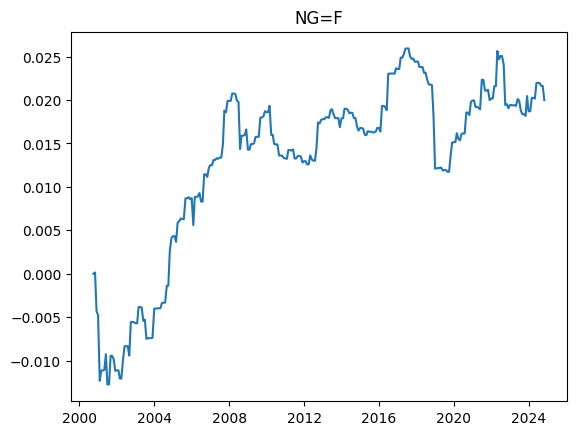

In [39]:
df["positions"] = positions
df["insamp_ret"] = df.r*df.positions
plt.plot(np.log((1+df.insamp_ret).cumprod()),label="insamp_monthlies")
plt.title(contract)
plt.show()
plt.close()

In [72]:
fpvals = [multiple_tests[j]["f_test"] for j in range(k)]
# 모델 평가에는 f_pval의 조화평균 사용
adj_pvals = k/np.sum([1/p for p in fpvals])

coeff_ps = multiple_tests[k-1]["t_tests"].values[1:]
coeff_vals = multiple_tests[k-1]["coeffs"].values[1:]
alpha = 0.5 #ignore to show all in sample graphs

'''in-sample portfolio construction using the regression model'''
seasons = np.multiply(np.where(coeff_ps < alpha,1,0),coeff_vals)
votess = np.array([np.multiply(x,seasons) for x in X])
positions = np.array([np.sum(votes) for votes in votess])

In [74]:
print(seasons, '\n')
print(votess[:][:5], '\n')
print(positions[:5])

[-0.         -0.          0.01669535] 

[[-0.         -0.          0.        ]
 [-0.         -0.          0.        ]
 [-0.         -0.          0.        ]
 [-0.         -0.          0.        ]
 [-0.         -0.          0.01669535]] 

[0.         0.         0.         0.         0.01669535]


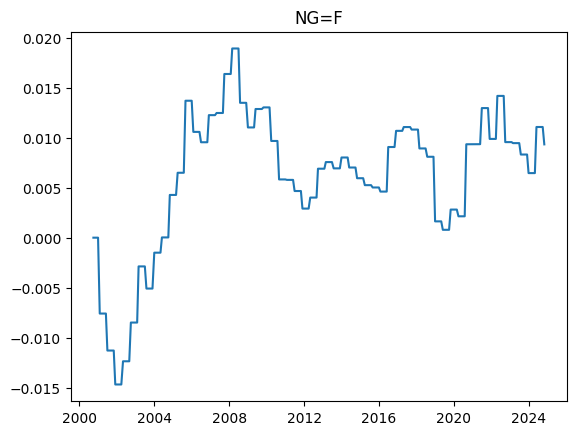

In [66]:
df["positions"] = positions
df["insamp_ret"] = df.r*df.positions
plt.plot(np.log((1+df.insamp_ret).cumprod()),label="insamp_monthlies")
plt.title(contract)
plt.show()
plt.close()